# CNN Face Recognition

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score
from IPython.display import display
from PIL import Image
import numpy as np
import zipfile
import seaborn
import dlib
import cv2
import os

### Detecting facial points

In [3]:
face_detector = dlib.get_frontal_face_detector()
points_detector = dlib.shape_predictor('../material/Weights/shape_predictor_68_face_landmarks.dat')

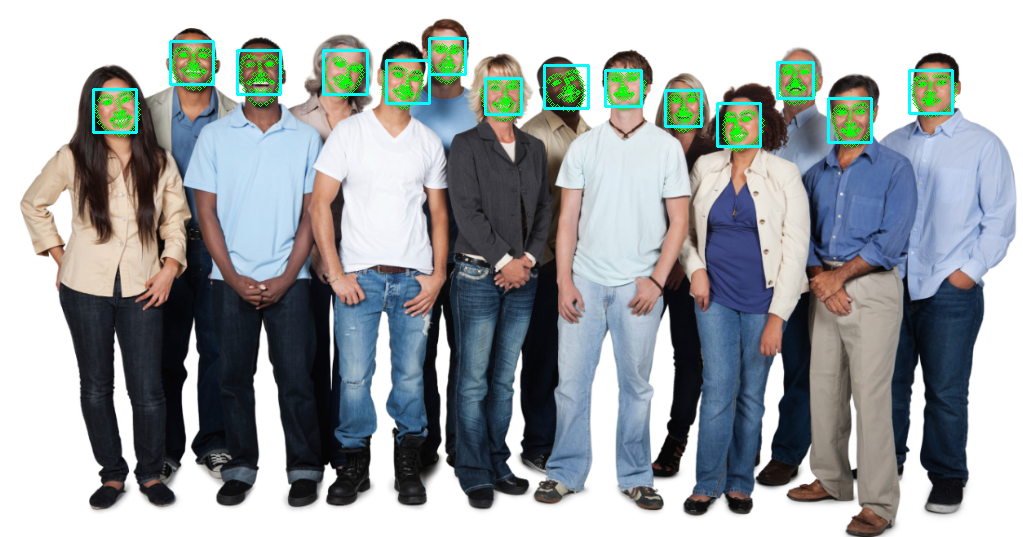

In [5]:
image = cv2.imread('../material/Images/people2.jpg')
face_detection = face_detector(image, 1)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for face in face_detection:
    points = points_detector(image, face)
    for point in points.parts():
        cv2.circle(image_rgb, (point.x, point.y), 2, (0,255,0), 1)
    l, t, r, b = face.left(), face.top(), face.right(), face.bottom()
    cv2.rectangle(image_rgb, (l, t), (r, b), (0,255,255), 2)

display(Image.fromarray(image_rgb))

### Detecting facial descriptors

In [6]:
# Resnet: https://arxiv.org/abs/1512.03385
face_descriptor_extractor = dlib.face_recognition_model_v1('../material/Weights/dlib_face_recognition_resnet_model_v1.dat')

In [8]:
index = {}
idx = 0
face_descriptors = None

paths = [os.path.join('./yalefaces/train', f) for f in os.listdir('./yalefaces/train')]
for path in paths:
    image = Image.open(path).convert('RGB')
    image_np = np.array(image, 'uint8')
    face_detection = face_detector(image_np, 1)
    for face in face_detection:
        l, t, r, b = face.left(), face.top(), face.right(), face.bottom()
        cv2.rectangle(image_np, (l, t), (r, b), (0, 0, 255), 2)

    points = points_detector(image_np, face)
    for point in points.parts():
        cv2.circle(image_np, (point.x, point.y), 2, (0, 255, 0), 1)

    face_descriptor = face_descriptor_extractor.compute_face_descriptor(image_np, points)

    face_descriptor = [f for f in face_descriptor]

    face_descriptor = np.asarray(face_descriptor, dtype=np.float64)

    face_descriptor = face_descriptor[np.newaxis, :]

    if face_descriptors is None:
        face_descriptors = face_descriptor
    else:
        face_descriptors = np.concatenate((face_descriptors, face_descriptor), axis = 0)

    index[idx] = path
    idx += 1

In [10]:
face_descriptors.shape

(135, 128)

In [11]:
face_descriptors

array([[-0.15350468,  0.07426192,  0.04148553, ..., -0.02009641,
         0.1433588 ,  0.04606313],
       [-0.16389525,  0.07845436,  0.10400572, ..., -0.00969113,
         0.10305433,  0.07807305],
       [-0.14073747,  0.07509376,  0.03072121, ...,  0.03921736,
         0.06639349,  0.02861481],
       ...,
       [-0.15216467,  0.06840789,  0.10447599, ..., -0.01414931,
         0.12608847,  0.03556602],
       [-0.14409296,  0.14637566,  0.05931809, ..., -0.11854263,
         0.15625978,  0.1010228 ],
       [-0.14766218,  0.11716866,  0.02476319, ...,  0.01745196,
         0.10112254, -0.00205604]])

In [12]:
len(index)

135

In [13]:
index

{0: './yalefaces/train/subject08.wink.gif',
 1: './yalefaces/train/subject09.wink.gif',
 2: './yalefaces/train/subject02.glasses.gif',
 3: './yalefaces/train/subject15.happy.gif',
 4: './yalefaces/train/subject06.noglasses.gif',
 5: './yalefaces/train/subject11.noglasses.gif',
 6: './yalefaces/train/subject03.sad.gif',
 7: './yalefaces/train/subject05.normal.gif',
 8: './yalefaces/train/subject14.leftlight.gif',
 9: './yalefaces/train/subject15.noglasses.gif',
 10: './yalefaces/train/subject02.noglasses.gif',
 11: './yalefaces/train/subject06.rightlight.gif',
 12: './yalefaces/train/subject13.rightlight.gif',
 13: './yalefaces/train/subject06.centerlight.gif',
 14: './yalefaces/train/subject10.leftlight.gif',
 15: './yalefaces/train/subject09.centerlight.gif',
 16: './yalefaces/train/subject02.wink.gif',
 17: './yalefaces/train/subject03.wink.gif',
 18: './yalefaces/train/subject11.sleepy.gif',
 19: './yalefaces/train/subject14.rightlight.gif',
 20: './yalefaces/train/subject01.rightli

### Calculating the distance between faces

In [14]:
face_descriptors[131]

array([-0.04352808,  0.09274483,  0.01334906, -0.01230733, -0.07162204,
       -0.01555828, -0.0242549 , -0.07681757,  0.20435201, -0.04511995,
        0.2270827 , -0.0411416 , -0.23025323, -0.03593551, -0.14735599,
        0.15288997, -0.08181304, -0.0662767 , -0.15494987, -0.0988914 ,
       -0.00406038,  0.05237981,  0.02291136, -0.03212617, -0.16270012,
       -0.22119409, -0.09860426, -0.10471994,  0.09028591, -0.0905017 ,
        0.01449624,  0.12462382, -0.23235297, -0.10641038,  0.04642592,
        0.00047397, -0.08652776, -0.02081744,  0.23060803,  0.10403004,
       -0.10741976,  0.15315099,  0.03229258,  0.29958269,  0.1694738 ,
        0.00437936,  0.00195169, -0.11563809,  0.04106015, -0.21929365,
        0.04983334,  0.18882269,  0.11552203,  0.10500835,  0.10880095,
       -0.11391712,  0.02331129,  0.11430028, -0.18899842,  0.11494502,
        0.09547889,  0.00901259, -0.09165646, -0.0573754 ,  0.10254867,
        0.07792377, -0.11140417, -0.06008442,  0.2255443 , -0.10

In [15]:
# https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html#numpy.linalg.norm
np.linalg.norm(face_descriptors[131] - face_descriptors[131])

0.0

In [16]:
np.linalg.norm(face_descriptors[131] - face_descriptors[130])

0.5155780170327636

In [17]:
np.linalg.norm(face_descriptors[131] - face_descriptors[107])

0.34686502343565956

In [18]:
np.linalg.norm(face_descriptors[131] - face_descriptors[128])

0.6908756929124907

In [19]:
np.linalg.norm(face_descriptors[0] - face_descriptors, axis = 1)

array([0.        , 0.67500773, 0.72054193, 0.62420838, 0.60993778,
       0.75950948, 0.6767537 , 0.77109194, 0.65048872, 0.63239044,
       0.78949368, 0.66277717, 0.61874477, 0.6214834 , 0.73358799,
       0.73299639, 0.77030394, 0.664118  , 0.7663518 , 0.57789395,
       0.73554462, 0.25501613, 0.54020674, 0.83090886, 0.6524869 ,
       0.7549542 , 0.75846294, 0.81586298, 0.69919375, 0.55694276,
       0.41725609, 0.83337433, 0.78509978, 0.71768766, 0.8152202 ,
       0.78250725, 0.71303545, 0.79638016, 0.72817434, 0.60152414,
       0.6984634 , 0.56401973, 0.68296582, 0.79046444, 0.75883628,
       0.53038011, 0.77442759, 0.84175451, 0.66702764, 0.76199941,
       0.48104882, 0.7208493 , 0.77693818, 0.72983075, 0.55160471,
       0.7896358 , 0.29506148, 0.79232629, 0.32409613, 0.35883231,
       0.77688152, 0.35556493, 0.77164249, 0.53720984, 0.78949368,
       0.80882957, 0.62146252, 0.74440236, 0.76670987, 0.74823694,
       0.76184722, 0.79258435, 0.69715565, 0.54361413, 0.73453

In [20]:
np.argmin(np.linalg.norm(face_descriptors[0] - face_descriptors[1:], axis = 1))

20

In [22]:
np.linalg.norm(face_descriptors[0] - face_descriptors[1:], axis = 1)[20]

0.25501612510330407

### Detecting faces with Dlib

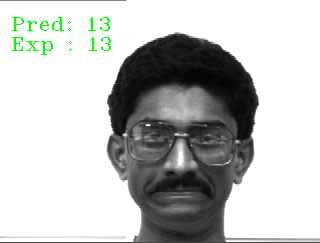

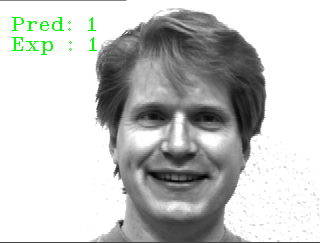

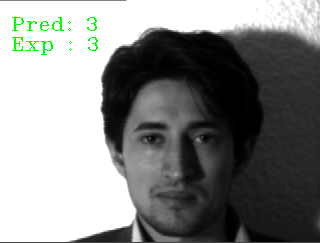

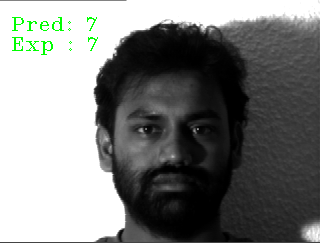

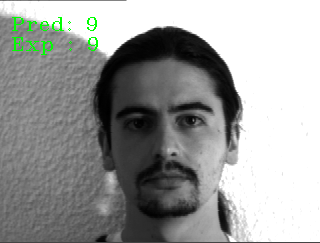

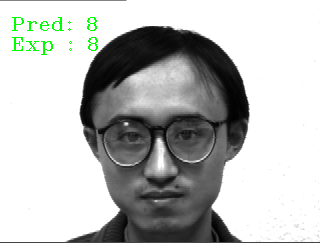

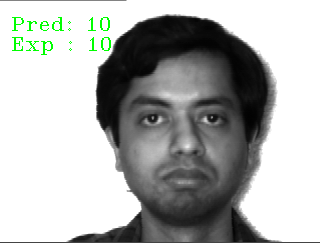

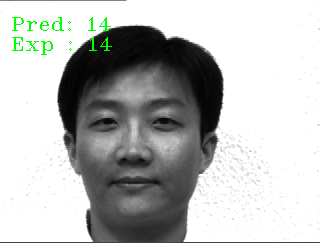

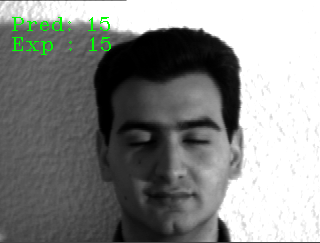

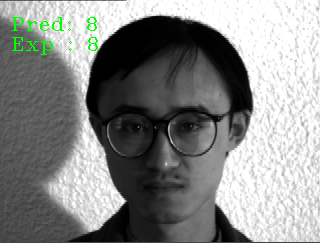

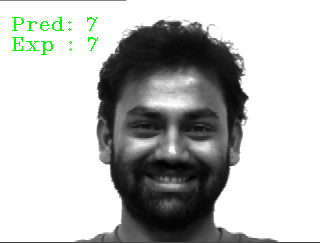

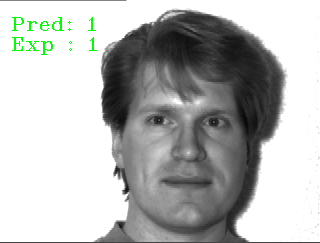

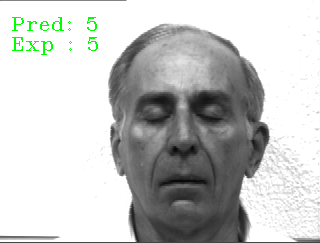

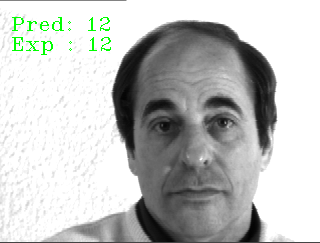

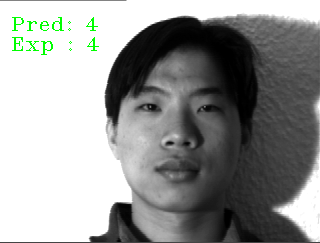

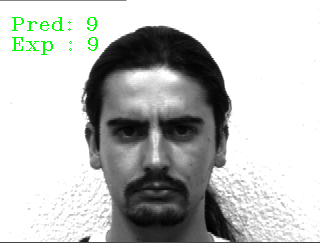

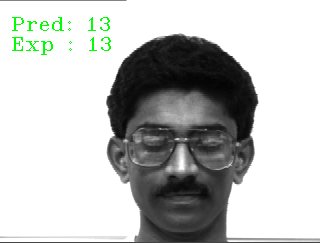

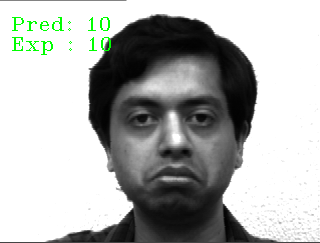

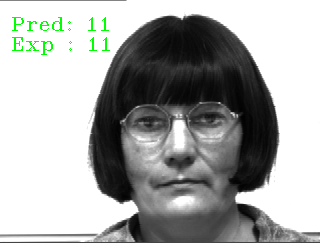

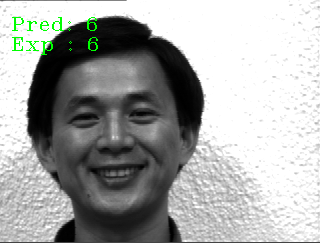

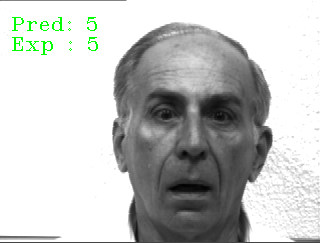

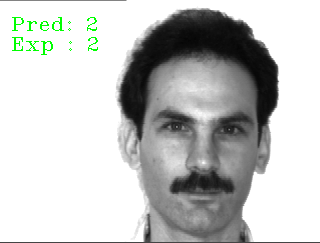

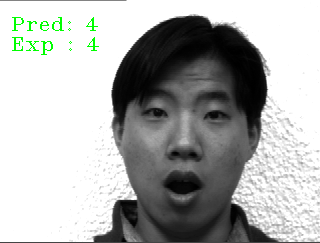

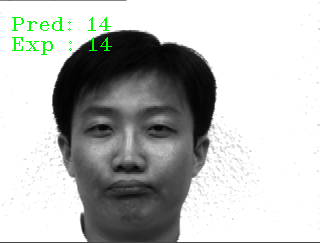

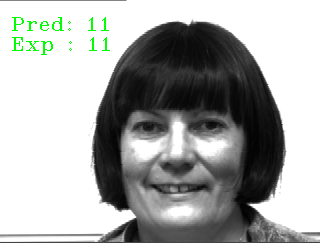

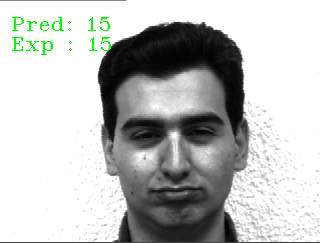

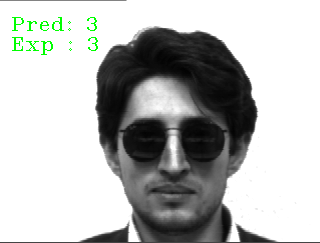

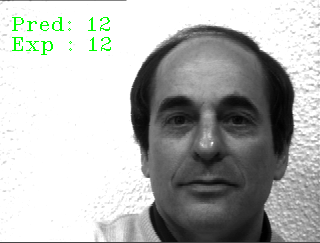

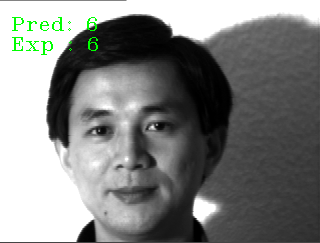

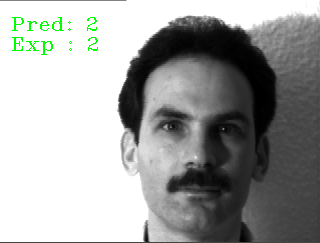

In [23]:
threshold = 0.5
predictions = []
expected_outputs = []

paths = [os.path.join('./yalefaces/test', f) for f in os.listdir('./yalefaces/test')]
for path in paths:
    image = Image.open(path).convert('RGB')
    image_np = np.array(image, 'uint8')
    face_detection = face_detector(image_np, 1)
    for face in face_detection:
        points = points_detector(image_np, face)
        face_descriptor = face_descriptor_extractor.compute_face_descriptor(image_np, points)
        face_descriptor = [f for f in face_descriptor]
        face_descriptor = np.asarray(face_descriptor, dtype=np.float64)
        face_descriptor = face_descriptor[np.newaxis, :]

    distances = np.linalg.norm(face_descriptor - face_descriptors, axis = 1)
    min_index = np.argmin(distances)
    min_distance = distances[min_index]
    if min_distance <= threshold:
        name_pred = int(os.path.split(index[min_index])[1].split('.')[0].replace('subject', ''))
    else:
        name_pred = 'Not identified'

    name_real = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))

    predictions.append(name_pred)
    expected_outputs.append(name_real)

    cv2.putText(image_np, 'Pred: ' + str(name_pred), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0))
    cv2.putText(image_np, 'Exp : ' + str(name_real), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0))

    display(Image.fromarray(image_np))

predictions = np.array(predictions)
expected_outputs = np.array(expected_outputs)

In [24]:
predictions

array([13,  1,  3,  7,  9,  8, 10, 14, 15,  8,  7,  1,  5, 12,  4,  9, 13,
       10, 11,  6,  5,  2,  4, 14, 11, 15,  3, 12,  6,  2])

In [25]:
expected_outputs

array([13,  1,  3,  7,  9,  8, 10, 14, 15,  8,  7,  1,  5, 12,  4,  9, 13,
       10, 11,  6,  5,  2,  4, 14, 11, 15,  3, 12,  6,  2])

In [27]:
accuracy_score(expected_outputs, predictions)

1.0